In [3]:
import pandas as pd
import numpy as np

from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [4]:
seed = 42

In [34]:
def evaluate_model(clf, X_test, y_test, name='Not specified'):
    
    print(f"Class distribution in test data:\nNormal: {len(y_test[y_test==0])}\nFraud: {len(y_test[y_test==1])}")
    
    fig, axes = plt.subplots(1,2, figsize=(20,6))
    
    # Confusion Matrix
    plot_confusion_matrix(clf, X_test, y_test, normalize=None,
                          display_labels=['Normal', 'Fraud'], cmap='Greens', ax=axes[0])
    axes[0].set_title('Confusion Matrix\n')
    
    plot_confusion_matrix(clf, X_test, y_test, normalize='true',
                          display_labels=['Normal', 'Fraud'], cmap='Greens', ax=axes[1])
    axes[1].set_title('Confusion Matrix\nnormalized')
    
    # Precision Recall Curve
    plot_precision_recall_curve(clf, X_test, y_test, name=name)
    plt.title('Precision Recall Curve')

## Data Preparation

### Import Dataset

In [5]:
df = pd.read_csv("../data/creditcard.csv")
print(f"Rows: {df.shape[0]}")
print(f"Cols: {df.shape[1]}")

Rows: 284807
Cols: 31


### Scale Time and Amount

In [6]:
# df.Time = StandardScaler().fit_transform(df.Time.values.reshape(-1, 1))
# df.Amount = StandardScaler().fit_transform(df.Amount.values.reshape(-1, 1))

In [7]:
for col in df.drop('Class', axis=1).columns:
    print(f"Scaling {col}")
    df[col] = StandardScaler().fit_transform(df[col].values.reshape(-1, 1))

Scaling Time
Scaling V1
Scaling V2
Scaling V3
Scaling V4
Scaling V5
Scaling V6
Scaling V7
Scaling V8
Scaling V9
Scaling V10
Scaling V11
Scaling V12
Scaling V13
Scaling V14
Scaling V15
Scaling V16
Scaling V17
Scaling V18
Scaling V19
Scaling V20
Scaling V21
Scaling V22
Scaling V23
Scaling V24
Scaling V25
Scaling V26
Scaling V27
Scaling V28
Scaling Amount


### Split data to get test set

In [8]:
X_orig = df.drop('Class', axis=1)
y_orig = df.Class

With stratification we make sure to keep the ration of normal and fraudulent transactions

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_orig, y_orig, test_size=0.3,
                                                    random_state=seed, stratify=y_orig)

In [10]:
print(f"Train samples: {y_train.shape[0]}")
print(f"Test samples: {y_test.shape[0]}")
print(f"Ratio: {y_test.shape[0]/y_orig.shape[0]}")

Train samples: 199364
Test samples: 85443
Ratio: 0.3000031600346902


## Option 1: Logistic Regression

### K-Fold Cross Validation

In [242]:
K = 5
scoring = 'recall'
parameters = {
    'C':[0.01, 0.1, 1, 10, 100],
    'max_iter':[500]
}

In [243]:
GSCV_1 = GridSearchCV(LogisticRegression(random_state=seed),
                      cv=K, param_grid=parameters, scoring=scoring, n_jobs=-1, verbose=2)

In [244]:
GSCV_1.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   31.0s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'max_iter': [500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=2)

In [245]:
clf_1 = GSCV_1.best_estimator_

In [246]:
GSCV_1.best_score_

0.6480392156862745

### Evaluate Model on test set

Class distribution in test data:
Normal: 85295
Fraud: 148


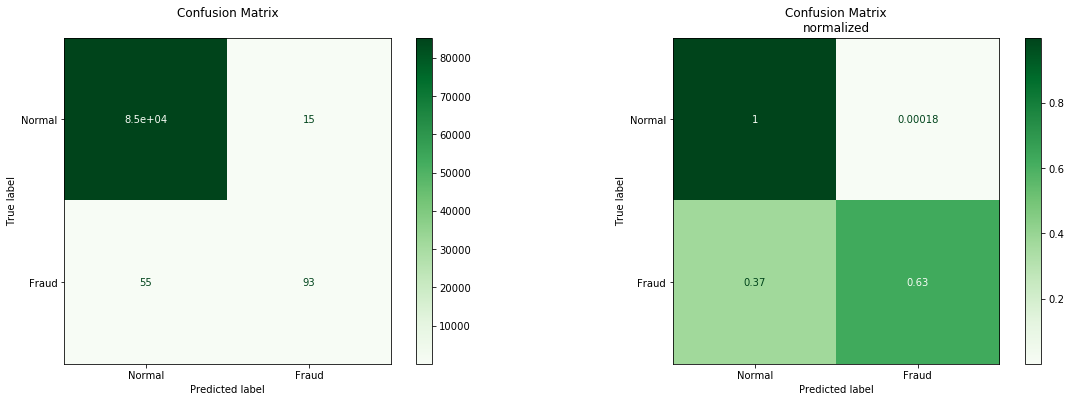

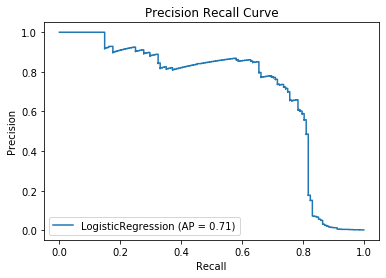

In [286]:
evaluate_model(clf_1, X_test, y_test, 'LogisticRegression')

## Option 2: Autoencoder + Logistic Regression

### Randomly select a subset of normal transcations for the Autoencoder training

In [117]:
X_train_norm = X_train[y_train == 0]
X_train_norm.shape

(199020, 30)

In [118]:
X_train_AE = X_train_norm.sample(frac=0.25, random_state=seed)
X_train_AE.shape

(49755, 30)

In [119]:
# Remove AE samples from classifier training data
X_train_clf = X_train.drop(X_train_AE.index)
y_train_clf = y_train.drop(X_train_AE.index)

### Train Autoencoder

In [120]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers

print(tf.__version__)

2.0.0


In [140]:
input_dim = X_train_AE.shape[1]

## input layer 
input_layer = Input(shape=(input_dim,)) # num_features

## encoding part
encoded = Dense(500, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(250, activation='relu')(encoded)
encoded = Dense(5, activation='relu')(encoded)

## decoding part
decoded = Dense(10, activation='tanh')(encoded)
decoded = Dense(20, activation='tanh')(decoded)

## output layer
output_layer = Dense(input_dim, activation='relu')(decoded)

In [141]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(learning_rate=0.002,
                    optimizer="adadelta", loss="mse")

In [142]:
autoencoder.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense_36 (Dense)             (None, 500)               15500     
_________________________________________________________________
dense_37 (Dense)             (None, 250)               125250    
_________________________________________________________________
dense_38 (Dense)             (None, 5)                 1255      
_________________________________________________________________
dense_39 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_40 (Dense)             (None, 20)                220       
_________________________________________________________________
dense_41 (Dense)             (None, 30)                630 

In [143]:
autoencoder.fit(X_train_AE.values, X_train_AE.values, 
                batch_size=64, epochs=100, 
                shuffle=True, validation_split=0.20);

Train on 39804 samples, validate on 9951 samples
Epoch 1/100
39804/39804 [==============================] - 5s 134us/sample - loss: 0.9949 - val_loss: 1.0455
Epoch 2/100
39804/39804 [==============================] - 4s 100us/sample - loss: 0.9900 - val_loss: 1.0407
Epoch 3/100
39804/39804 [==============================] - 4s 99us/sample - loss: 0.9856 - val_loss: 1.0364
Epoch 4/100
39804/39804 [==============================] - 4s 113us/sample - loss: 0.9817 - val_loss: 1.0325
Epoch 5/100
39804/39804 [==============================] - 5s 129us/sample - loss: 0.9784 - val_loss: 1.0292
Epoch 6/100
39804/39804 [==============================] - 4s 109us/sample - loss: 0.9754 - val_loss: 1.0262
Epoch 7/100
39804/39804 [==============================] - 5s 116us/sample - loss: 0.9728 - val_loss: 1.0235
Epoch 8/100
39804/39804 [==============================] - 5s 119us/sample - loss: 0.9703 - val_loss: 1.0211
Epoch 9/100
39804/39804 [==============================] - 4s 108us/sample - los

### Latent representation

In [144]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

def extract_latent(data):
    return hidden_representation.predict(data)

In [145]:
X_train_clf_lat = extract_latent(X_train_clf)

### Logistic Regression

In [14]:
K = 5
scoring = 'recall'
parameters = {
    'C':[0.01, 0.1, 1, 10, 100],
    'max_iter':[500]
}

In [147]:
GSCV_2 = GridSearchCV(LogisticRegression(random_state=seed),
                      cv=K, param_grid=parameters, scoring=scoring, n_jobs=-1, verbose=2)

In [148]:
GSCV_2.fit(X_train_clf_lat, y_train_clf)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  3.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'max_iter': [500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=2)

In [149]:
clf_2 = GSCV_2.best_estimator_

In [150]:
GSCV_2.best_score_

0.7964194373401534

### Evaluate on test set

In [151]:
X_test_lat = extract_latent(X_test)

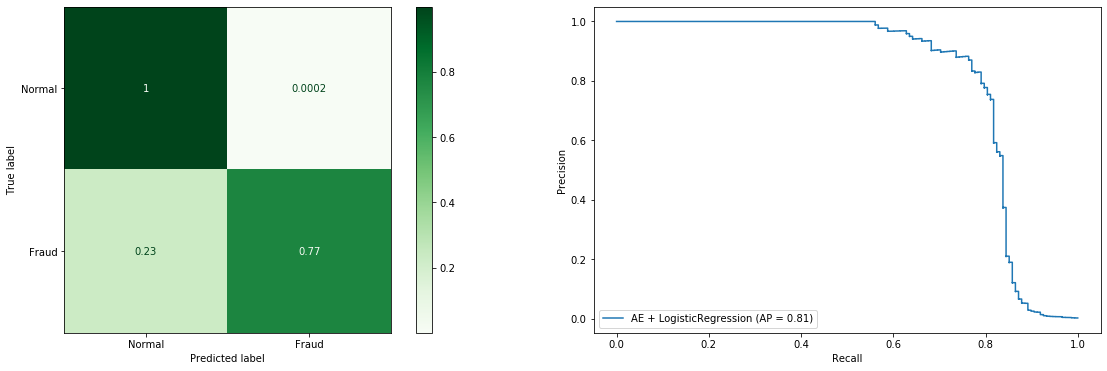

In [152]:
evaluate_model(clf_2, X_test_lat, y_test, 'AE + LogisticRegression')

## Option 3: Over-sampling + Logistic Regression

In [305]:
def manual_cv(sampler, log_reg_params):
    
    SKF = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)
    
    avg_accuracy_scores = []
    avg_recall_scores = []
    avg_f1_scores = []

    for C in log_reg_params['C']:

        accuracy_scores = []
        recall_scores = []
        f1_scores = []

        for train_index, val_index in SKF.split(X_train, y_train):

            # Sample each train_split separately
            X_sampled, y_sampled = sampler.fit_resample(X_train.iloc[train_index], y_train.iloc[train_index])

            # Train Classifier
            # TODO: Add parameters
            clf = LogisticRegression(random_state=seed, C=C, max_iter=500).fit(X_sampled, y_sampled)

            # Validate model
            X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
            y_pred = clf.predict(X_val)

            recall_scores.append(recall_score(y_val, y_pred))
            accuracy_scores.append(accuracy_score(y_val, y_pred))
            f1_scores.append(f1_score(y_val, y_pred))

        print(f"Tested model with C = {C}")
        print(f"Mean accuracy:\t {np.mean(accuracy_scores)}")
        print(f"Mean recall:\t {np.mean(recall_scores)}")
        print(f"Mean f1-score:\t {np.mean(f1_scores)}")
        print()

        avg_accuracy_scores.append(np.mean(accuracy_scores))
        avg_recall_scores.append(np.mean(recall_scores))
        avg_f1_scores.append(np.mean(f1_scores))
        
    return avg_accuracy_scores, avg_recall_scores, avg_f1_scores

### Cross Validation

In [28]:
parameters = {
    'classification__C':[0.01, 0.1, 1, 10, 100],
    'classification__max_iter':[500]
}

In [313]:
smote = SMOTE(sampling_strategy='minority', random_state=seed)

In [201]:
avg_accuracy_scores, avg_recall_scores, avg_f1_scores = manual_cv(smote, parameters)

D:\Miniconda3\envs\creditcardfraud\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
D:\Miniconda3\envs\creditcardfraud\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
D:\Miniconda3\envs\creditcardfraud\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
D:\Miniconda3\envs\creditcardfraud\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in

---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9773830752677874
precision: 0.06607987411095777
recall: 0.918542199488491
f1: 0.12326782602059642
---------------------------------------------------------------------------------------------------------------------------------------


In [11]:
from imblearn.pipeline import Pipeline

In [29]:
model = Pipeline([
        ('sampling', SMOTE(sampling_strategy='minority', random_state=seed)),
        ('classification', LogisticRegression(random_state=seed))
    ])

In [42]:
GSCV_3 = GridSearchCV(model,
                      cv=K, param_grid=parameters, scoring='f1', n_jobs=-1, verbose=2)

In [43]:
GSCV_3.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('sampling',
                                        SMOTE(k_neighbors=5, kind='deprecated',
                                              m_neighbors='deprecated',
                                              n_jobs=1, out_step='deprecated',
                                              random_state=42, ratio=None,
                                              sampling_strategy='minority',
                                              svm_estimator='deprecated')),
                                       ('classification',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=T...
                                                          

In [44]:
clf_3 = GSCV_3.best_estimator_

### Evaluation on test set

In [314]:
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [316]:
clf_3 = LogisticRegression(random_state=seed, C=0.01, max_iter=500).fit(X_train_smote, y_train_smote)

Class distribution in test data:
Normal: 85295
Fraud: 148


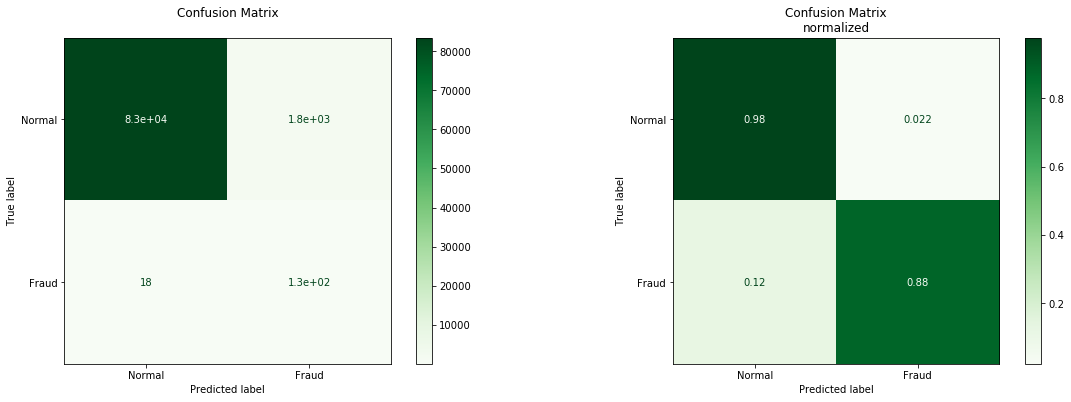

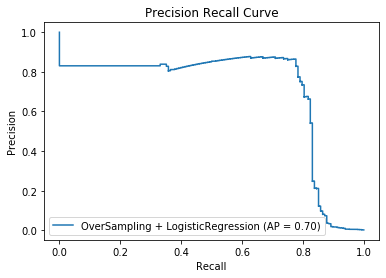

In [317]:
evaluate_model(clf_3, X_test, y_test, 'OverSampling + LogisticRegression')

Class distribution in test data:
Normal: 85295
Fraud: 148


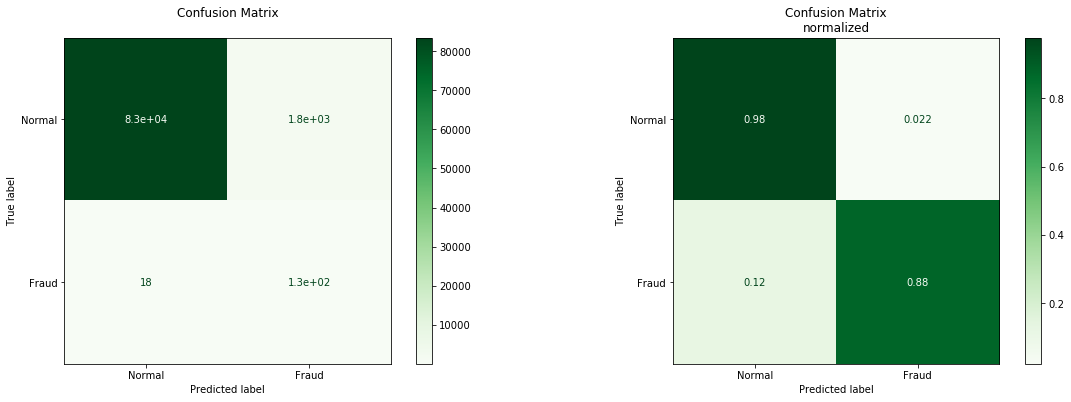

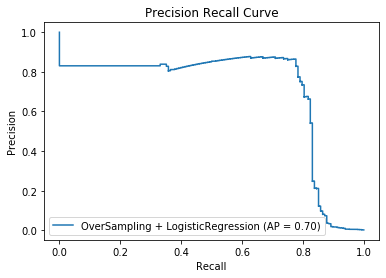

In [45]:
smote = SMOTE(sampling_strategy='minority', random_state=seed)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
evaluate_model(clf_3, X_test, y_test, 'OverSampling + LogisticRegression')

## Option 4: Under-sampling + Logistic Regression

In [306]:
parameters = {
    'C':[0.01, 0.1, 1, 10, 100],
}

In [307]:
rus = RandomUnderSampler(sampling_strategy='majority', random_state=seed) # define sampling method

In [308]:
avg_accuracy_scores, avg_recall_scores, avg_f1_scores = manual_cv(rus, parameters)

Tested model with C = 0.01
Mean accuracy:	 0.991427744968284
Mean recall:	 0.8864876385336743
Mean f1-score:	 0.2636873217251682

Tested model with C = 0.1
Mean accuracy:	 0.9811751460666912
Mean recall:	 0.9156436487638533
Mean f1-score:	 0.1447958938602489

Tested model with C = 1
Mean accuracy:	 0.9711933940622632
Mean recall:	 0.9243393009377664
Mean f1-score:	 0.10156045126135922

Tested model with C = 10
Mean accuracy:	 0.9672508434836384
Mean recall:	 0.9243393009377664
Mean f1-score:	 0.09037098889952237

Tested model with C = 100
Mean accuracy:	 0.9650638688651073
Mean recall:	 0.918542199488491
Mean f1-score:	 0.08537542631621389



In [296]:
avg_recall_scores

[0.8864876385336743,
 0.9156436487638533,
 0.9243393009377664,
 0.9243393009377664,
 0.918542199488491]

In [297]:
avg_accuracy_scores

[0.991427744968284,
 0.9811751460666912,
 0.9711933940622632,
 0.9672508434836384,
 0.9650638688651073]

In [298]:
avg_f1_scores

[0.2636873217251682,
 0.1447958938602489,
 0.10156045126135922,
 0.09037098889952237,
 0.08537542631621389]

### Evaluate on test set

In [318]:
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

In [321]:
clf_4 = LogisticRegression(random_state=seed, C=0.01, max_iter=500).fit(X_train_rus, y_train_rus)

Class distribution in test data:
Normal: 85295
Fraud: 148


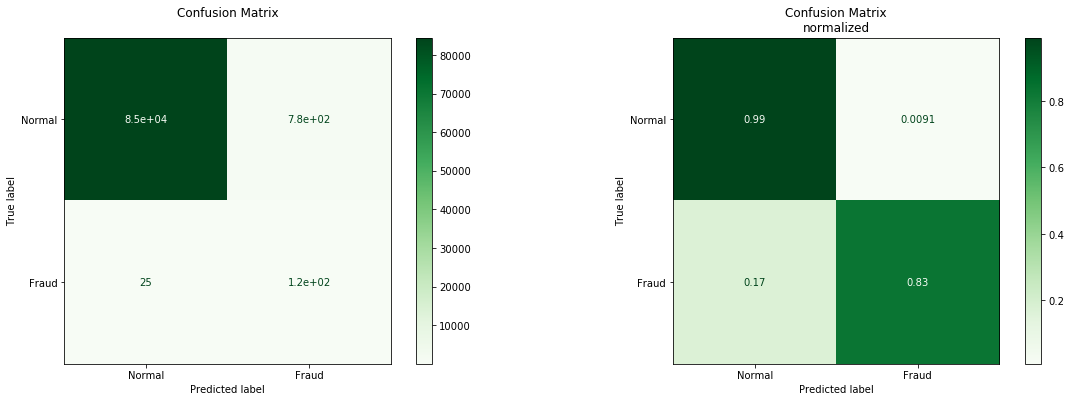

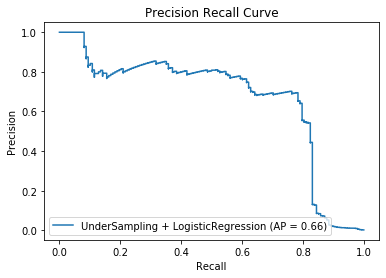

In [322]:
evaluate_model(clf_4, X_test, y_test, 'UnderSampling + LogisticRegression')

## Summary